In [1]:
%matplotlib inline
## imports

# site
from scipy.ndimage.morphology import binary_erosion
from matplotlib import pyplot as plt
from shapely.geometry import asShape, Point
from rasterstats import point_query
import pandas as pd
import numpy as np
import rasterio
import fiona
import flopy

# std
from pathlib import Path
import datetime
import yaml

flopy is installed in C:\Miniconda3\lib\site-packages\flopy


In [2]:
def read_array(rasterfile, row, col, masked=True, band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)[row, col]

In [3]:
def read_array_2d(rasterfile, masked=True, band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)

In [4]:
def read_profile(rasterfile):
    with rasterio.open(rasterfile) as src:
        return src.profile

In [5]:
def write_array(rasterfile, values, profile):
    with rasterio.open(rasterfile, 'w', **profile) as dst:
        return dst.write(values, 1)

In [6]:
def read_arrays(rasterfiles, row, col, stack_axis=0):
    arrays = []
    for rasterfile in rasterfiles:
        arrays.append(read_array(rasterfile, row, col))
    return np.stack(arrays, axis=stack_axis)

In [7]:
def save_int(datfile, array):
    save_array(datfile, array, fmt='%i', delimiter=' ')


In [8]:
def save_float(datfile, array):
    save_array(datfile, array, fmt='%15.6E')

In [9]:
def save_array(datfile, array, fmt, delimiter=''):
    np.savetxt(datfile, array, fmt=fmt, delimiter=delimiter)

In [10]:
def read_shape(shapefile):
    with fiona.open(shapefile) as src:
        for row in src:
            yield asShape(row['geometry']), row['properties']

In [11]:
t0 = datetime.datetime.now()

In [12]:
## input
# name
name = 'mf6brabant_ext'

# workspace
workspace = Path(r'..\output\mf6brabant_triangles')

# exe name
mf_exe = Path(r'..\bin\mf6.0.3\bin\mf6.exe')
triangle_exe = Path(r'C:\dev\triangle\triangle.exe')

# spatial reference
xllcorner = 60_000.
yllcorner = 322_500.

# grid dimensions
nlay = 19
nrow = 450
ncol = 601
delr = 250.
delc = 250.

# data files
topfile = Path(r'..\data\topbot\RL{ilay:d}.tif')
botfile = Path(r'..\data\topbot\TH{ilay:d}.tif')
idomainfile = Path(r'..\data\boundary\ibound.tif')
               
kdfile = Path(r'..\data\kdc\TX{ilay:d}.tif')
cfile = Path(r'..\data\kdc\CL{ilay:d}.tif')
             
startfile = Path(r'..\data\startingheads\HH{ilay:d}.tif')

rechargefile = Path(r'..\data\recharge\RP1.tif')

drn2005file = Path(r'..\data\mf2005\drn_data.csv')
ghb2005file = Path(r'..\data\mf2005\ghb_data.csv')
riv2005file = Path(r'..\data\mf2005\riv_data.csv')

sqfile = Path(r'..\data\wells\sq_list.csv')
boundaryfile = Path(r'..\data\boundary\boundary.shp')
polfile = Path(r'')

In [13]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [14]:
# grid
boundary = [gm for gm, _ in read_shape(boundaryfile)][0]
pol = Point([150_000., 380_000.]).buffer(1e4).simplify(tolerance=1e2)

In [15]:
from flopy.utils.triangle import Triangle
tri = Triangle(angle=30, model_ws=workspace, exe_name=str(triangle_exe))
tri.add_polygon(boundary.exterior.coords[:-1])
tri.add_polygon(pol.exterior.coords[:-1])
tri.add_region(boundary.centroid.coords[0], attribute=0, maximum_area=1e7)
tri.add_region(pol.centroid.coords[0], attribute=1, maximum_area=1e6)
tri.build(verbose=True)


Opening _triangle.0.poly.
Opening _triangle.0.node.
Constructing Delaunay triangulation by divide-and-conquer method.
  Sorting vertices.
  Forming triangulation.
  Removing ghost triangles.
Recovering segments in Delaunay triangulation.
    Constructing mapping from vertices to triangles.
  Recovering PSLG segments.
Removing unwanted triangles.
  Marking concavities (external triangles) for elimination.
  Marking neighbors of marked triangles.
  Deleting marked triangles.
Spreading regional attributes and area constraints.
Adding Steiner points to enforce quality.
  Looking for encroached subsegments.
  Splitting encroached subsegments.
  Making a list of bad triangles.
  Splitting bad triangles.

Writing _triangle.1.node.
Writing _triangle.1.ele.
Writing _triangle.1.poly.
Writing _triangle.1.edge.
Writing _triangle.1.neigh.

Statistics:

  Input vertices: 86
  Input segments: 86
  Input holes: 0

  Mesh vertices: 1337
  Mesh triangles: 2527
  Mesh edges: 3863
  Mesh exterior boundary

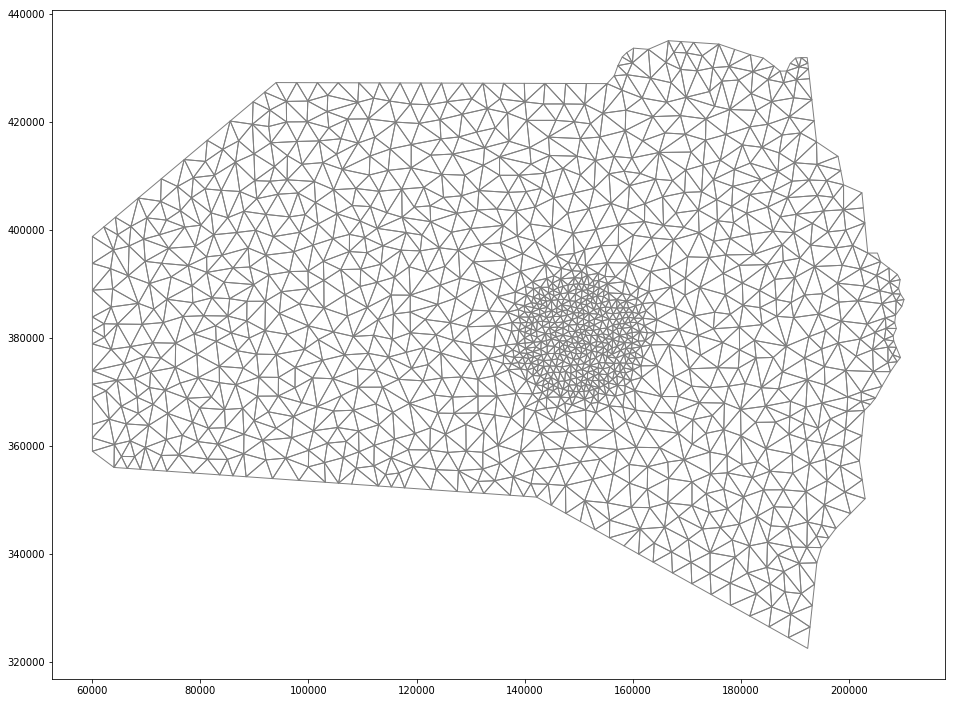

In [16]:
fig, ax = plt.subplots(figsize=(16., 16.))
tri.plot(ax=ax, edgecolor='gray', facecolor='none')
ax.set_aspect('equal')

In [17]:
xc, yc = zip(*tri.get_xcyc())
fwd = rasterio.transform.from_origin(xllcorner, yllcorner + nrow*delr, delc, delr)
row, col = rasterio.transform.rowcol(fwd, xc, yc)

In [18]:
# create data directory
datafolder = workspace / 'data'
datafolder.mkdir(exist_ok=True)

In [19]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name=str(mf_exe), 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
    model_nam_file=model_nam_file,
    save_flows=True,
    )

In [20]:
# read tops
topfiles = (topfile.parent / topfile.name.format(ilay=i + 1) for i in range(nlay))
tops = read_arrays(topfiles, row, col)

In [21]:
# read bots
botfiles = (botfile.parent / botfile.name.format(ilay=i + 1) for i in range(nlay))
bots = read_arrays(botfiles, row, col)

In [22]:
# convert to top, botm
top = tops[0, :]
topdatfile = datafolder / 'top.dat'
save_float(topdatfile, top)
top_ext = {'filename': str(topdatfile.relative_to(workspace))}
botm_ext = []
for ilay in range(nlay):
    botm = bots[ilay, :]
    botmdatfile = datafolder / 'botm_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(botmdatfile, botm)
    botm_ext.append({'filename': str(botmdatfile.relative_to(workspace))})
    if (ilay + 1) < nlay:
        botm = tops[ilay + 1, :]
        botmdatfile = datafolder / 'botm_l{ilay:02d}.dat'.format(ilay=ilay*2 + 2)
        save_float(botmdatfile, botm)
        botm_ext.append({'filename': str(botmdatfile.relative_to(workspace))})

In [23]:
# read idomain
idomain = read_array_2d(idomainfile).astype(np.int)
# idomaindatfile = datafolder / 'idomain.dat'
# save_int(idomaindatfile, idomain)
# idomain_ext = [{'filename': str(idomaindatfile.relative_to(workspace))} for i in range(nlay*2 - 1)]

In [24]:
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
ncpl = tri.ncpl
nvert = tri.nvert

# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdisv.ModflowGwfdisv(gwf,
    pname='dis', nlay=(nlay*2 - 1),
    ncpl=ncpl, nvert=nvert,
    vertices=vertices, cell2d=cell2d,
    top=top_ext, botm=botm_ext,
    idomain=1,
    length_units='METERS',
    )

In [25]:
# read kD
kdfiles = (kdfile.parent / kdfile.name.format(ilay=i + 1) for i in range(nlay))
kd = read_arrays(kdfiles, row, col)

# convert to kh
kh = (kd / (tops - bots))

# fill with low value
kh = kh.filled(1e-6)

# write to file
kh_ext = []
for ilay in range(nlay):
    khdatfile = datafolder / 'kh_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(khdatfile, kh[ilay, :])
    kh_ext.append(
        {'filename': str(khdatfile.relative_to(workspace))},
        )
    if (ilay + 1) < nlay:
        # dummy values
        kh_ext.append(1e-6)

In [26]:
# read c
cfiles = (cfile.parent / cfile.name.format(ilay=i + 1) for i in range(nlay - 1))
c = read_arrays(cfiles, row, col)

# convert to kv
kv = (bots[:-1, :] - tops[1:, :]) / c

# fill with high value
kv = kv.filled(1e6)

# write to file
kv_ext = []
for ilay in range(nlay):
    # dummy values
    kv_ext.append(1e6)
    if (ilay + 1) < nlay:
        kvdatfile = datafolder / 'kv_l{ilay:02d}.dat'.format(ilay=ilay*2 + 2)
        save_float(kvdatfile, kv[ilay, :])
        kv_ext.append(
            {'filename': str(kvdatfile.relative_to(workspace))},
            )

In [27]:
# initialize the NPF package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    model=gwf,
    k=kh_ext,
    k22=kh_ext,
    k33=kv_ext,
)

In [28]:
# read start
startfiles = (startfile.parent / startfile.name.format(ilay=i + 1) for i in range(nlay))
start = read_arrays(startfiles, row, col)

# mask values larger than 1000
start = np.ma.masked_where(start.mask | (start > 1e3), start)

# fill masked with zeros
start = start.filled(0.)

start_ext = []
for ilay in range(nlay):
    startdatfile = datafolder / 'start_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(startdatfile, start[ilay, :])
    start_ext.append(
        {'filename': str(startdatfile.relative_to(workspace))},
        )
    if (ilay + 1) < nlay:
        start_ext.append(
            {'filename': str(startdatfile.relative_to(workspace))},
            )

In [29]:
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=start_ext)

In [30]:
# get boundary data from idomain and starting heads
chd_data = []
for ilay in range(dis.nlay.get_data()):    
    for node in tri.get_edge_cells(1):
        chd_data.append((ilay + 1, node + 1, start[ilay//2, node]))
chd_data = np.array(
    chd_data,
    dtype=[('ilay', np.int), ('node', np.int), ('value', np.float)]
    )
chddatfile = datafolder / 'chd.dat'
save_array(chddatfile, chd_data, fmt='  %i %i %16.8f')
chd_ext = {0: {
    'filename': str(chddatfile.relative_to(workspace)),
    }}

In [31]:
# initialize the CHD package
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf,
    pname='chd',
    maxbound=len(chd_data),
    stress_period_data=chd_ext,
    )

In [32]:
# recharge
recharge = read_array(rechargefile, row, col)
rechargedatfile = datafolder / 'recharge.dat'
save_float(rechargedatfile, recharge)
recharge_ext = [{'filename': str(rechargedatfile.relative_to(workspace))}]

In [33]:
# initialize the RCH package
rch = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge_ext)

In [34]:
from scipy.spatial import cKDTree
tree = cKDTree(tri.get_xcyc())

In [35]:
# DRN stress period data from Modflow 2005
drn2005_data = pd.read_csv(drn2005file)

# select active cells
is_active = (idomain == 1)[drn2005_data.loc[:, 'i'], drn2005_data.loc[:, 'j']]


drn_data = drn2005_data.loc[is_active, ['k', 'i', 'j', 'elev0', 'cond0']]
drn_data.loc[:, 'k'] *= 2

x, y = rasterio.transform.xy(fwd, drn_data.loc[:, 'i'], drn_data.loc[:, 'j'])
xy = np.array([x, y]).transpose()
distances, nodes = tree.query(xy)
drn_data.loc[:, 'node'] = nodes
drn_data.loc[:, ['k', 'node']] += 1
drn_data = drn_data.loc[:, ['k', 'node', 'elev0', 'cond0']]

drndatfile = datafolder / 'drn.dat'
save_array(drndatfile, drn_data.values, fmt='  %i %i %16.8f %16.8f')
drn_ext = {0: {
    'filename': str(drndatfile.relative_to(workspace)),
    }}

# initialize the DRN package
drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,
    pname='drn',
    maxbound=drn_data.shape[0],
    stress_period_data=drn_ext,
    )

In [36]:
# GHB stress period data from Modflow 2005
ghb2005_data = pd.read_csv(ghb2005file)

# select active cells
is_active = (idomain == 1)[ghb2005_data.loc[:, 'i'], ghb2005_data.loc[:, 'j']]


ghb_data = ghb2005_data.loc[is_active, ['k', 'i', 'j', 'bhead0', 'cond0']]
ghb_data.loc[:, 'k'] *= 2

x, y = rasterio.transform.xy(fwd, ghb_data.loc[:, 'i'], ghb_data.loc[:, 'j'])
xy = np.array([x, y]).transpose()
distances, nodes = tree.query(xy)
ghb_data.loc[:, 'node'] = nodes
ghb_data.loc[:, ['k', 'node']] += 1
ghb_data = ghb_data.loc[:, ['k', 'node', 'bhead0', 'cond0']]

ghbdatfile = datafolder / 'ghb.dat'
save_array(ghbdatfile, ghb_data.values, fmt='  %i %i %16.8f %16.8f')
ghb_ext = {0: {
    'filename': str(ghbdatfile.relative_to(workspace)),
    }}

# initialize the GHB package
ghb = flopy.mf6.modflow.mfgwfghb.ModflowGwfghb(gwf,
    pname='ghb',
    maxbound=ghb_data.shape[0],
    stress_period_data=ghb_ext,
    )

In [37]:
# RIV stress period data from Modflow 2005
riv2005_data = pd.read_csv(riv2005file)

# select active cells
is_active = (idomain == 1)[riv2005_data.loc[:, 'i'], riv2005_data.loc[:, 'j']]


riv_data = riv2005_data.loc[is_active, ['k', 'i', 'j', 'stage0', 'cond0', 'rbot0']]
riv_data.loc[:, 'k'] *= 2

x, y = rasterio.transform.xy(fwd, riv_data.loc[:, 'i'], riv_data.loc[:, 'j'])
xy = np.array([x, y]).transpose()
distances, nodes = tree.query(xy)
riv_data.loc[:, 'node'] = nodes
riv_data.loc[:, ['k', 'node']] += 1
riv_data = riv_data.loc[:, ['k', 'node', 'stage0', 'cond0', 'rbot0']]

rivdatfile = datafolder / 'riv.dat'
save_array(rivdatfile, riv_data.values, fmt='  %i %i %16.8f %16.8f %16.8f')
riv_ext = {0: {
    'filename': str(rivdatfile.relative_to(workspace)),
    }}

# initialize the RIV package
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,
    pname='riv',
    maxbound=riv_data.shape[0],
    stress_period_data=riv_ext,
    )

In [38]:
# read sources data from csv file
sqs = pd.read_csv(sqfile)

# to row,col from x,y
fwd = rasterio.transform.from_origin(xllcorner, yllcorner + nrow*delr, delc, delr)

# transform xy to row,col
sqs.loc[:, 'row'], sqs.loc[:, 'col'] = (
    rasterio.transform.rowcol(fwd, sqs['xcoordinate'], sqs['ycoordinate'])
    )

# select active cells
is_active = (idomain == 1)[sqs.loc[:, 'row'], sqs.loc[:, 'col']]

# layer numbers & pumping rates
wel_data = sqs.loc[is_active, ['ilay', 'xcoordinate', 'ycoordinate', 'q_assigned']]
wel_data.loc[:, 'ilay'] = wel_data.loc[:, 'ilay'] * 2 - 1

distances, nodes = tree.query(wel_data.loc[:, ['xcoordinate', 'ycoordinate']])
wel_data.loc[:, 'node'] = nodes + 1
wel_data = wel_data.loc[:, ['ilay', 'node', 'q_assigned']]

weldatfile = datafolder / 'wel.dat'
save_array(weldatfile, wel_data.values, fmt='  %i %i %16.8f')
wel_ext = {0: {
    'filename': str(weldatfile.relative_to(workspace)),
    }}

In [39]:
# initialize WEL package
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf,
    pname='wel',
    maxbound=len(wel_data),
    stress_period_data=wel_ext,
    )

In [40]:
# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', complexity='SIMPLE')

In [41]:
# Create the output control package
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord, 
                                            head_filerecord=head_filerecord,
                                            budget_filerecord=budget_filerecord,
                                            printrecord=printrecord)

In [42]:
# write simulation to new location
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6brabant_ext...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd...
    writing package rch...
    writing package drn...
    writing package ghb...
    writing package riv...
    writing package wel...
    writing package oc...


In [43]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: ..\bin\mf6.0.3\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.3 08/09/2018

   MODFLOW 6 compiled Aug 09 2018 13:40:32 with IFORT compiler (ver. 18.0.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resou

In [44]:
# read heads
headfile = workspace / '{name:}.hds'.format(name=name)
hds = flopy.utils.binaryfile.HeadFile(headfile)

In [45]:
t1 = datetime.datetime.now()
print('notebook execution took {}'.format(t1 - t0))

notebook execution took 0:00:36.140226


In [46]:
# read heads
headfile = workspace / '{name:}.hds'.format(name=name)
hds = flopy.utils.binaryfile.HeadFile(headfile)
heads = hds.get_data()

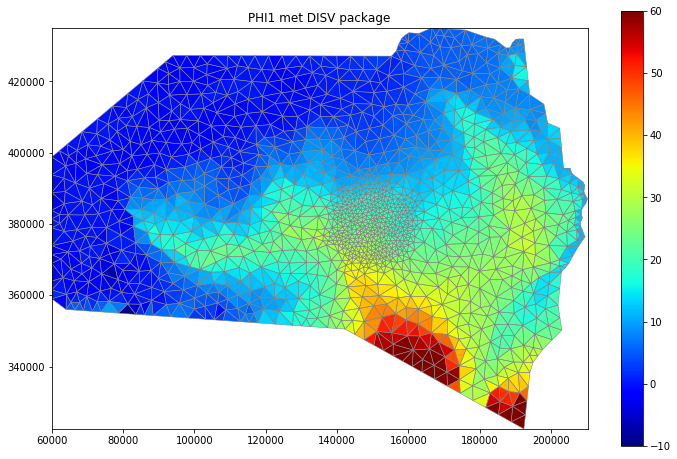

In [47]:
# plot heads
import matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
mm = flopy.plot.PlotMapView(gwf, ax=ax)

v = mm.plot_array(heads[0, :, :], cmap='jet', vmin=-10., vmax=60.)
mm.plot_grid(linewidth=0.5)
ax.set_aspect('equal')
ax.set_title('PHI1 met DISV package')
plt.colorbar(v)

plt.savefig(workspace / 'phi1.png', bbox_inches='tight')